In [1]:
import numpy as np
import scipy.integrate as integrate
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### 3 CVA/DVA Exercise

#### Market setup

##### Interest Rate Setup

In [17]:
spread = 0.005 # spread i.e. f_LIBOR=f_OIS+spread
f0_OIS = 0.02
f0_LIBOR = f0_OIS+spread
sim_freq = 12

freq = 2
maturity = 10

sigma_r = 0.02
c = 0.35
kappa1 = 0.02
kappa2 = 0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)*nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

###### Swap Object and Pricing

In [3]:
class Swap(object) :
    def __init__(self, maturity, coupon, freq) :
        '''
        Args:
            maturity: in years
            coupon:   fixed coupon, in decimal
            freq:     frequency of payments, 2 for semi-annual
        
        '''
        self.maturity = maturity
        self.coupon = coupon
        self.freq = freq
        
    def __str__(self) :
        return 'Swap: maturity %g, coupon %g, freq %g' % (self. maturity, self.coupon, self.freq)
    
def priceSwap(swap, payerOrReceiver, P_OIS, P_LIBOR, i) :
    '''
    Args:
        swap:     a swap object
        payerOrReceiver: string type, 'payer' or 'receiver'
        P_OIS:    array, discount bond price using OIS
        P_Libor:  array, discount bond price using LIBOR
        i:        time step now, takes positive integer
    '''
    ts = np.arange(dt,swap.maturity+1e-6,dt)
    #floating = 
    if payerOrReceiver == 'payer':
        net_payment = floating - swap.coupon
    else:
        net_payment = swap.coupon - floating
        
    return 

In [5]:
payer_swap = Swap(10,0.0265,2)
payer_swap.__str__()

'Swap: maturity 10, coupon 0.0265, freq 2'

###### Simulate OIS curve

From equation (18) and (19) from [1], we get $$\sigma_{22}=\sigma_2$$
$$\sigma_{21}=\sigma_1 \times \rho_x$$
$$\sigma_{11}=\sqrt{\sigma_1^2-\sigma_{21}^2}=\sqrt{\sigma_1^2-\sigma_1^2\times \rho_x^2}$$
For $y(t)$, we calculate the involved integral manually:
$$\int_{0}^{t}{a(u)^T a(u)du}=\int_{0}^{t} \begin{bmatrix} \sigma_{11}^2e^{2\kappa_1u} & \sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u}\\\sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u} & \sigma_{22}^2e^{2\kappa_2u} \end{bmatrix}du \\=\begin{bmatrix} \frac{\sigma_{11}^2+\sigma_{21}^2}{2\kappa_1}(e^{2\kappa_1t}-1) & \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) \\ \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) & \frac{\sigma_{22}^2}{2\kappa_2}(e^{2\kappa_2t}-1)\end{bmatrix}$$
For $P(t,x(t),T)$, we know $$P(t,x(t),T)=e^{-\int_{t}^{T} f(t,x(t),u)du}$$ where $$f(t,x(t),u)=f(0,u)+M(t,u)^T(x(t)+y(t)G(t,u))$$
Since $f(0,u)$ is constant, then $$P(t,x(t),T)=e^{-f(0,T)+f(0,t)}e^{-x(t)\int_{t}^{T}M(t,u)du}e^{-y(t)\int_{t}^{T}M(t,u)^TG(t,u)du}\\=\frac{P(0,T)}{P(0,t)}exp\big(-G(t,T)^Tx(t)-\frac{1}{2}G(t,T)^Ty(t)G(t,T)\big)$$
where $$M(t,T)=\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}$$
and $$G(t,T)=\int_{t}^{T}M(t,u)du=\int_{t}^{T}\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}du\\=\begin{bmatrix} \frac{1-\kappa_1(T-t)}{\kappa_1} \\ \frac{1-\kappa_2(T-t)}{\kappa_2}\end{bmatrix}$$

In [6]:
# test
a = np.asarray([2,0,1,2])
print len(a)

4


In [7]:
def simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity,ts):
    '''
    Args:
        sim_freq: simulation frequency for rate curves, 12 for monthly
    
    '''
    sigma22 = sigma2
    sigma21 = sigma1*rho_x
    sigma11 = np.sqrt(sigma1**2 *(1 - rho_x*rho_x))
    
    
    x = np.asarray([0,0])
    C = np.asarray([[1,0],[rho_x,1.-rho_x*rho_x]]) # Cholesky decomposition of corr matrix for Brownian motion
    xt = []
    yt = []
    
    for i in range(maturity*sim_freq):
        wt = C.dot(np.random.normal(0,1./sim_freq,(2,)))
        B = np.diag([np.exp(-kappa1*ts[i]),np.exp(-kappa2*ts[i])])
        
        integral_aa11 = (sigma11**2+sigma21**2)/2./kappa1*(np.exp(2*kappa1*ts[i])-1.)
        integral_aa12 = sigma21*sigma22/(kappa1+kappa2)*(np.exp((kappa1+kappa2)*ts[i])-1.)
        integral_aa22 = sigma22**2 /2./kappa2*(np.exp(2*kappa2*ts[i]-1.))
        integral_aa = np.asarray([[integral_aa11,integral_aa12],[integral_aa12,integral_aa22]])
        #print (integrate.fixed_quad(integrant_aa,0,ts[i])[0])
        y = B.dot(integral_aa).dot(B)
        
        x = x + (y.dot(np.ones(2))-np.diag([kappa1,kappa2]).dot(x))*1./sim_freq+np.diag([sigma1,sigma2]).dot(wt)
        xt.append(x)
        yt.append(y)
        
    return xt,yt

In [8]:
xt,yt= simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, 12, 10)
plot(xt)
legend(['x1','x2'],loc=1)

TypeError: simulateXt() takes exactly 8 arguments (7 given)

In [30]:
def simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, f0_Libor, spread):
    ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)
    Tis = np.arange(1./freq,maturity+1e-6,1./freq) # time steps when there is cash flow
    P_OIS = []
    P_LIBOR = []
    
    P_OIS.append([np.exp(-f0_OIS*t) for t in ts]) # calculate P_OIS(0,t) for all t
    P_LIBOR.append([P_OIS[0][i]*np.exp(spread*ts[i]) for i in range(ts.shape[0])])# calculate P_LIBOR(0,t) for all t
    xt,yt = simulateXt(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity,ts) #120 xt's and yt's
    for i in range(ts.shape[0]):
        P_OIS_t = []
        P_OIS_0_t = P_OIS[0][i]
        P_LIBOR_t = []
        for j in np.where(Tis>=ts[i])[0]: # index for all coupon paying dates after t
            #M = np.asarray([np.exp(-kappa1*(Tis[i]-t)),np.exp(-kappa2*(Tis[i]-t))])
            G = np.asarray([(1.-kappa1*(Tis[j]-ts[i]))/kappa1,(1.-kappa2*(Tis[j]-ts[i]))/kappa2])
            P_OIS_0_Ti = P_OIS[0][(j+1)*sim_freq/freq-1]
            P_OIS_t_Ti = P_OIS_0_Ti/P_OIS_0_t*np.exp(-G.T.dot(xt[i])-0.5*G.T.dot(yt[i]).dot(G))
            P_OIS_t.append(P_OIS_t_Ti)
            P_LIBOR_t.append(P_OIS_t_Ti*np.exp(spread*(Tis[j]-ts[i])))
            
        P_OIS.append(P_OIS_t)
        P_LIBOR.append(P_LIBOR_t)
        
    return P_OIS,P_LIBOR

[0.57657933344967405]


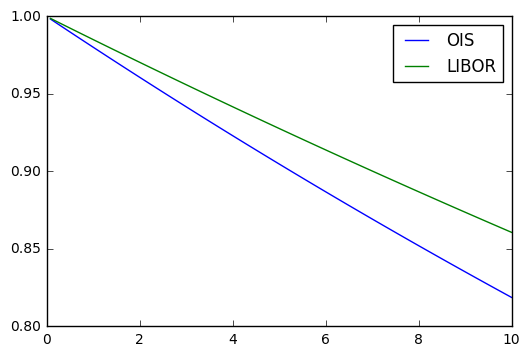

In [36]:
ois,libor = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, f0_LIBOR, spread)
#print ois
#print libor
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)
plot(ts,ois[0],ts,libor[0])
legend(['OIS','LIBOR'])
print ois[120]

In [ ]:
# test cell
rho_x = 0.5
C = np.asarray([[1,0],[rho_x,1-rho_x*rho_x]]) # Cholesky decomposition of correlation matrix
wt = C.dot(np.random.normal(0,1,(2,)))
print wt.shape
print np.ones(2).shape
print np.diag(np.asarray([2,3]))
print np.arange(1./12,10.00001,1./12)

### 4 IMM Exercise